In [44]:
import torch,torchvision
from torch import nn
import pandas as pd
import tqdm
import numpy as np
import matplotlib.pyplot as plt


In [45]:
from torchvision.datasets import MNIST
from torch.utils.data import Dataset,DataLoader
from torchvision.transforms import ToTensor

def one_hot_encoded(x):
    y=torch.zeros(10)
    y[x]=1
    return y

mnist_train = MNIST(root='./', train=True, download=True, transform=ToTensor(),target_transform=one_hot_encoded)
mnist_test = MNIST(root='./', train=False, download=True, transform=ToTensor(),target_transform=one_hot_encoded)

train_loader = DataLoader(mnist_train,batch_size=32)


In [46]:
from torch import nn
class vae(nn.Module):
    def __init__(self,input_shape,latent_shape):
        self.input_shape=input_shape
        self.latent_shape=latent_shape
        super(vae,self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(in_features= input_shape,out_features=512),
            nn.ReLU(),
            nn.Linear(in_features= 512,out_features=128),
            nn.ReLU(),
            nn.Linear(in_features= 128,out_features=32),
            nn.ReLU(),
        )
        self.mu = nn.Linear(in_features=32,out_features=latent_shape)
        self.log_var = nn.Linear(in_features=32,out_features=latent_shape)
        self.decoder = nn.Sequential(
            nn.Linear(in_features=latent_shape,out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128,out_features=512),
            nn.ReLU(),
            nn.Linear(in_features= 512,out_features=input_shape),
            nn.Sigmoid()
        )
    
        self.kl=0

    def forward(self,X : np.ndarray):
        encoded = self.encoder(X)
        zmean,z_log_var = self.mu(encoded),self.log_var(encoded)
        sampled = zmean + torch.rand_like(z_log_var)*torch.exp(0.5*z_log_var)
        decoded = self.decoder(sampled)
        self.kl = -0.5*(1+z_log_var - zmean**2 - torch.exp(z_log_var)).sum()
        return decoded 
    


Epoch 9 Loss 4327.5517578125: : 18750it [05:27, 57.32it/s]                        


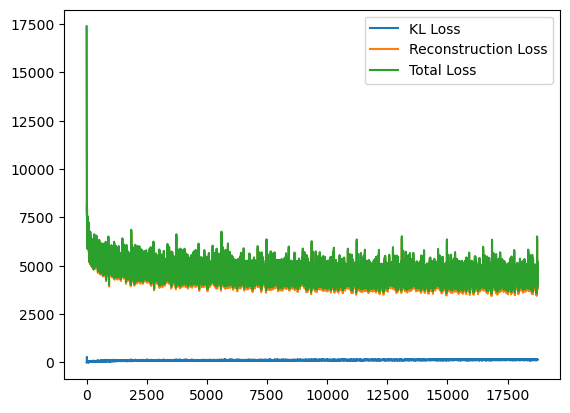

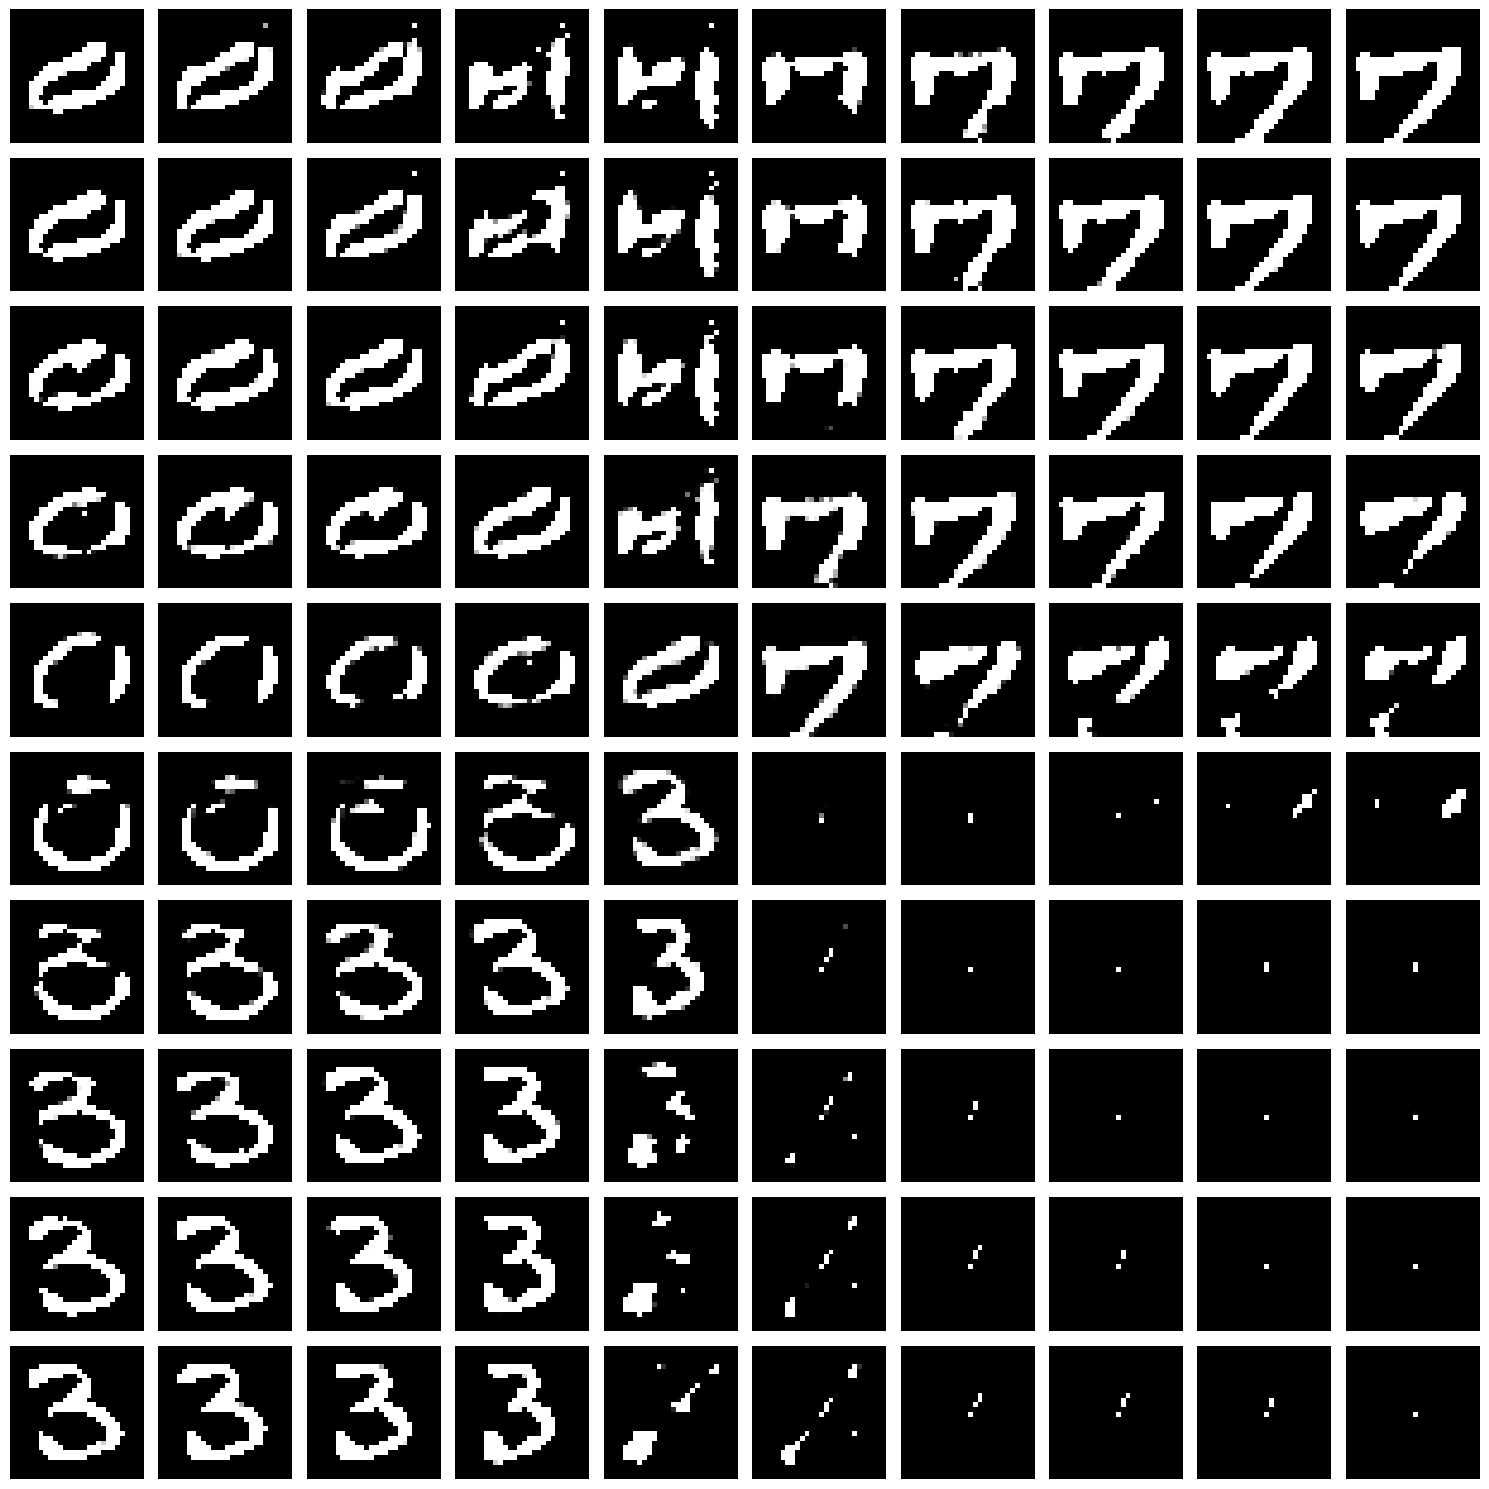

: 

In [ ]:
from tqdm import tqdm

model = vae(28*28,2).cuda()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

loss_fn = nn.BCELoss(reduction="sum")
num_epochs=10
kl_loss = []
recon_loss = []
total_loss = []
with tqdm(total=len(train_loader)) as pbar:
    for epoch in range(num_epochs):
        for image,_ in train_loader:
            image = image.view(-1,28*28).cuda()
            optimizer.zero_grad()
            decoded = model(image)
            kl_loss.append(model.kl.item())
            recon = loss_fn(decoded,image)
            loss = model.kl + recon
            recon_loss.append(recon.item())
            total_loss.append(loss.item())
            loss.backward()
            optimizer.step()
            pbar.update(1)
            pbar.set_description(f"Epoch {epoch} Loss {loss.item()}")
            if loss.item() < 0.1:
                break

plt.plot(kl_loss,label="KL Loss")
plt.plot(recon_loss,label="Reconstruction Loss")
plt.plot(total_loss,label="Total Loss")
plt.legend()
plt.show()
def visualize_latent_space(model, device='cuda'):
    # Create a grid of latent space coordinates
    grid_x, grid_y = torch.meshgrid(torch.linspace(-300, 300, 10), torch.linspace(-300, 300, 10))
    grid_z = torch.stack([grid_x.flatten(), grid_y.flatten()], dim=1).to(device)
    
    # Generate images from the latent vectors
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # No need to track gradients
        decoded = model.decoder(grid_z)
    
    # Reshape to grid and plot
    fig, axes = plt.subplots(10, 10, figsize=(15, 15))
    for i in range(10):
        for j in range(10):
            idx = i * 10 + j
            img = decoded[idx].view(28, 28).detach().cpu().numpy()
            axes[i, j].imshow(img, cmap='gray')  # MNIST is grayscale
            axes[i, j].axis('off')
    
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.tight_layout()
    plt.show()

visualize_latent_space(model)

Epoch 2 | Loss: 4623.6802 | Recon: 4605.7334 | KL: 17.9470:  10%|█         | 1881/18750 [00:58<09:02, 31.09it/s]

Epoch 1/10 | Total Loss: 5223.9728 | Recon: 5211.5326 | KL: 12.4402


Epoch 3 | Loss: 4715.2217 | Recon: 4701.3643 | KL: 13.8574:  20%|██        | 3756/18750 [02:01<08:47, 28.42it/s]

Epoch 2/10 | Total Loss: 4660.4341 | Recon: 4644.8734 | KL: 15.5608


Epoch 4 | Loss: 4482.3330 | Recon: 4466.2217 | KL: 16.1112:  30%|███       | 5630/18750 [03:02<07:49, 27.95it/s]

Epoch 3/10 | Total Loss: 4530.3331 | Recon: 4515.2472 | KL: 15.0860


Epoch 5 | Loss: 4509.4521 | Recon: 4492.9502 | KL: 16.5022:  40%|████      | 7506/18750 [04:04<05:27, 34.30it/s]

Epoch 4/10 | Total Loss: 4453.7827 | Recon: 4439.1883 | KL: 14.5945


Epoch 6 | Loss: 4266.0537 | Recon: 4253.6235 | KL: 12.4300:  50%|█████     | 9380/18750 [05:00<05:01, 31.03it/s]

Epoch 5/10 | Total Loss: 4400.8176 | Recon: 4386.7562 | KL: 14.0615


Epoch 7 | Loss: 3574.6162 | Recon: 3559.7637 | KL: 14.8525:  60%|██████    | 11256/18750 [05:59<04:01, 30.97it/s]

Epoch 6/10 | Total Loss: 4356.8941 | Recon: 4342.8294 | KL: 14.0647


Epoch 8 | Loss: 4248.1094 | Recon: 4234.0098 | KL: 14.0996:  70%|███████   | 13131/18750 [06:58<03:02, 30.85it/s]

Epoch 7/10 | Total Loss: 4335.8771 | Recon: 4321.7316 | KL: 14.1455


Epoch 9 | Loss: 3995.5740 | Recon: 3980.2417 | KL: 15.3323:  80%|████████  | 15006/18750 [07:57<02:08, 29.11it/s]

Epoch 8/10 | Total Loss: 4314.1731 | Recon: 4300.1876 | KL: 13.9854


Epoch 10 | Loss: 3667.1887 | Recon: 3651.4417 | KL: 15.7472:  90%|█████████ | 16880/18750 [08:56<01:00, 30.78it/s]

Epoch 9/10 | Total Loss: 4294.2941 | Recon: 4280.6024 | KL: 13.6917


Epoch 10 | Loss: 4603.7163 | Recon: 4589.7539 | KL: 13.9626: 100%|██████████| 18750/18750 [09:55<00:00, 31.50it/s]


Epoch 10/10 | Total Loss: 4283.3627 | Recon: 4269.6830 | KL: 13.6798


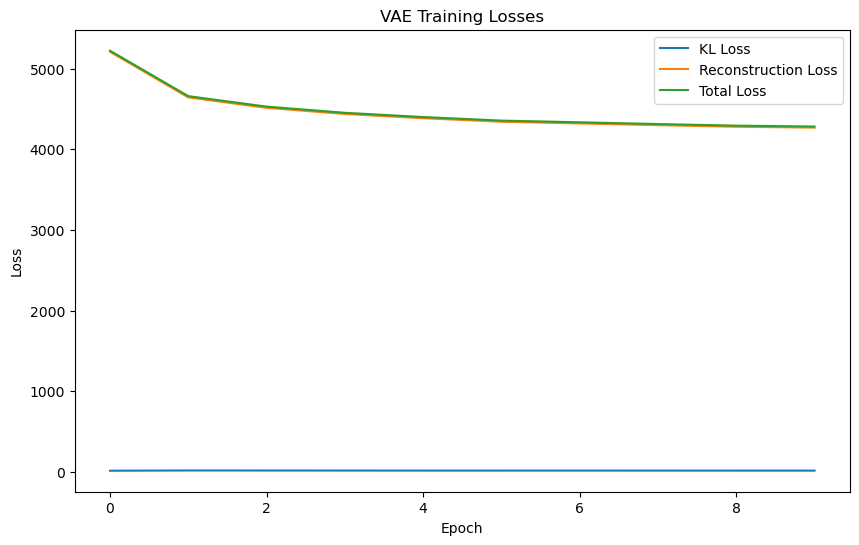

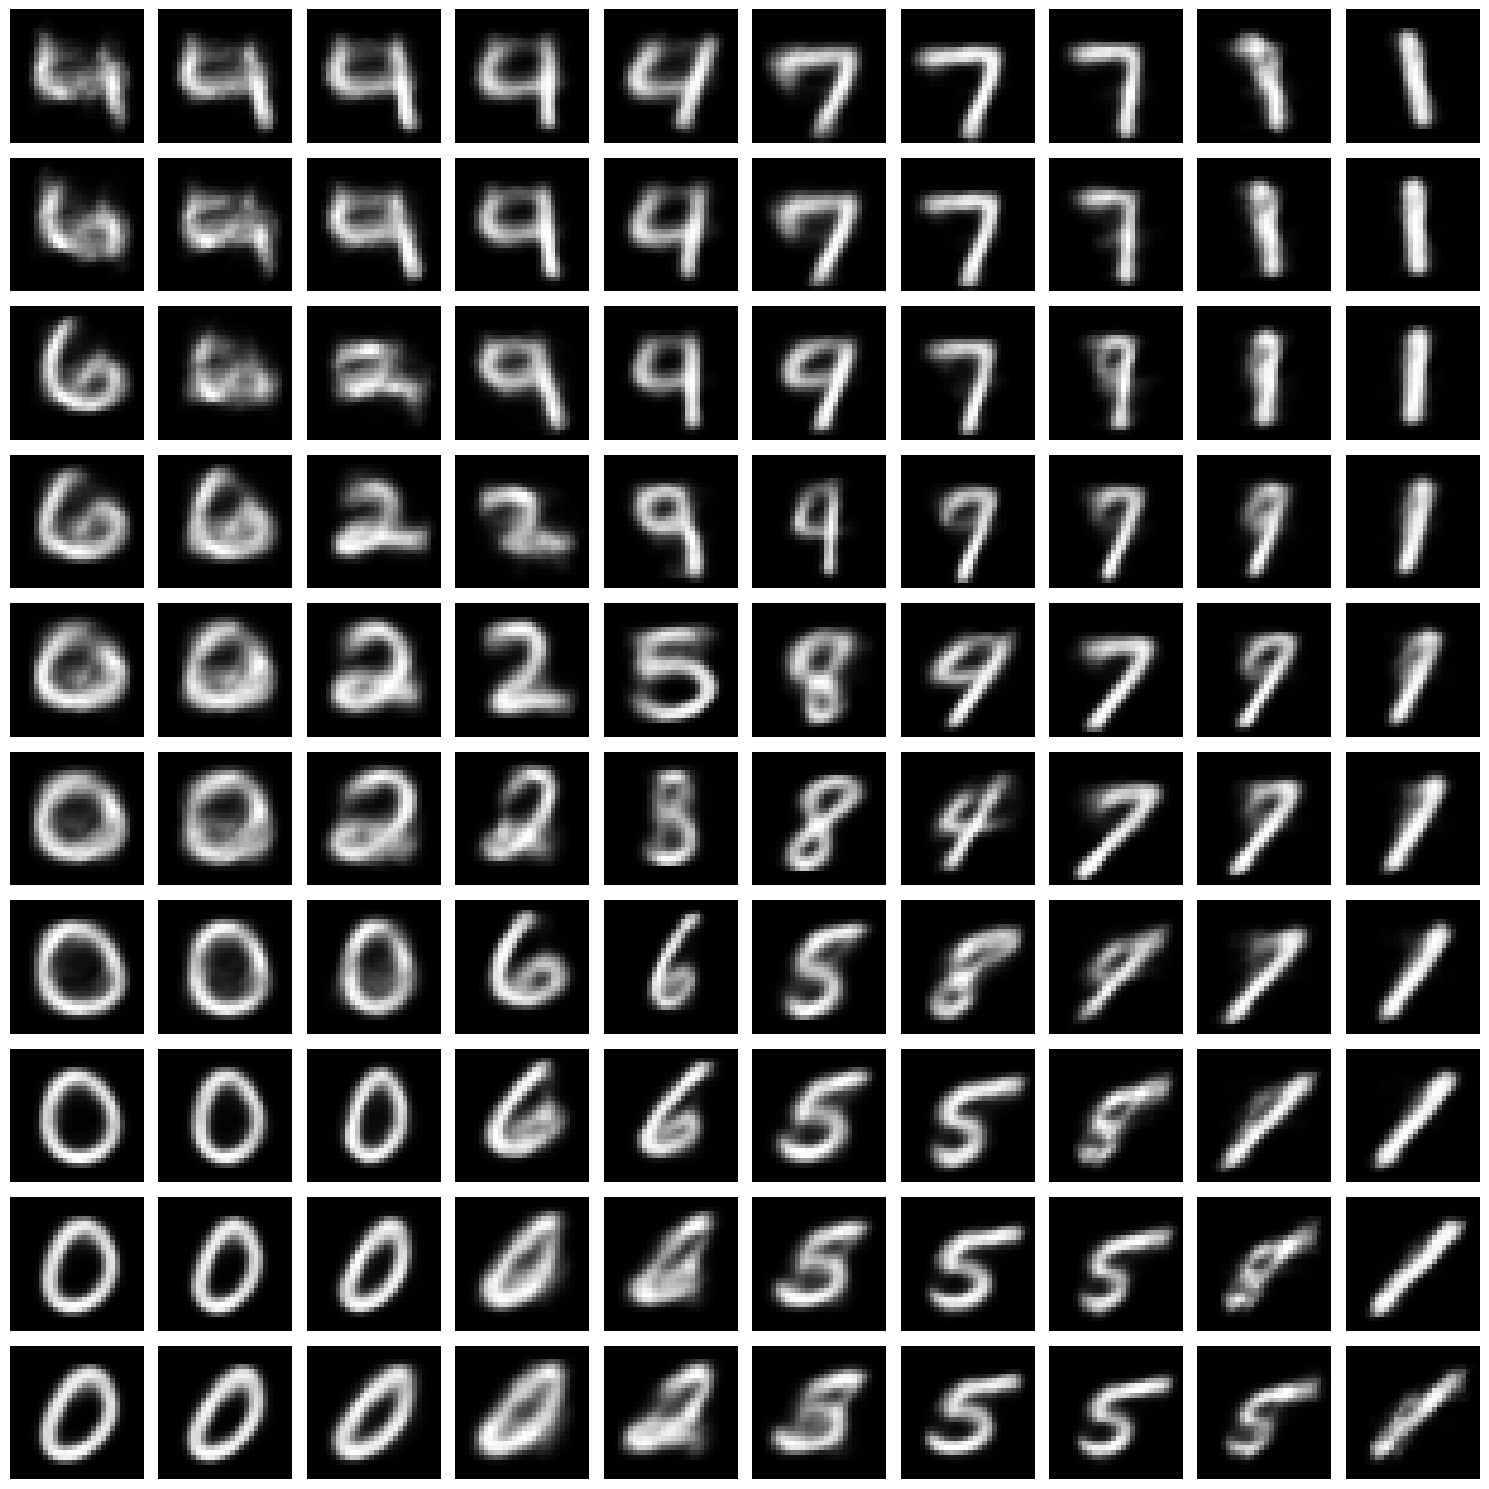

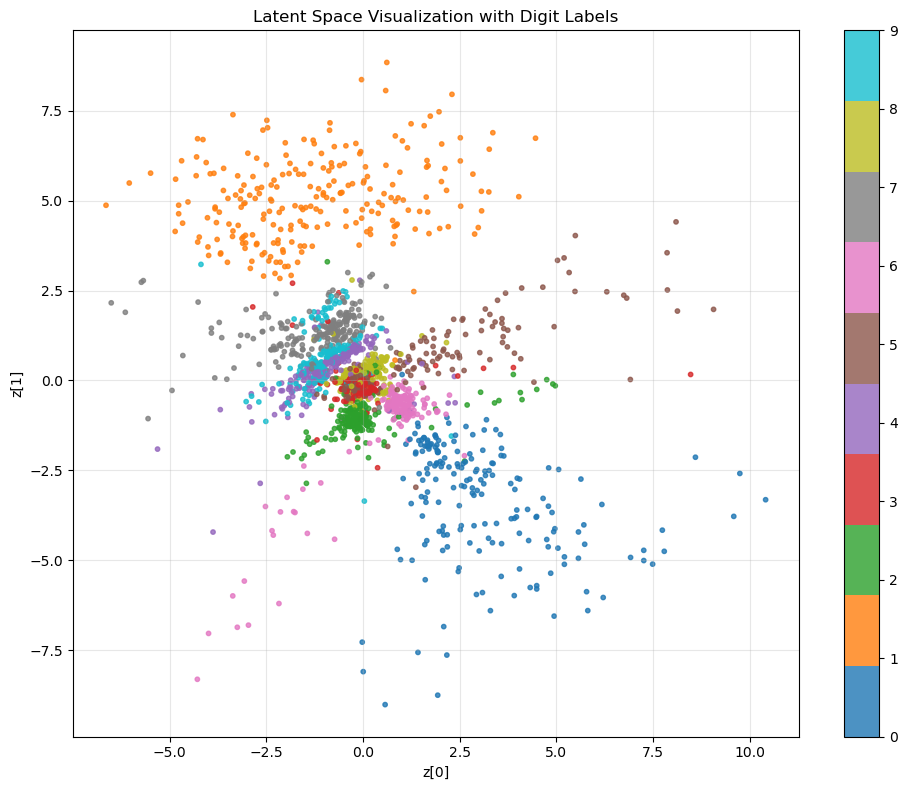

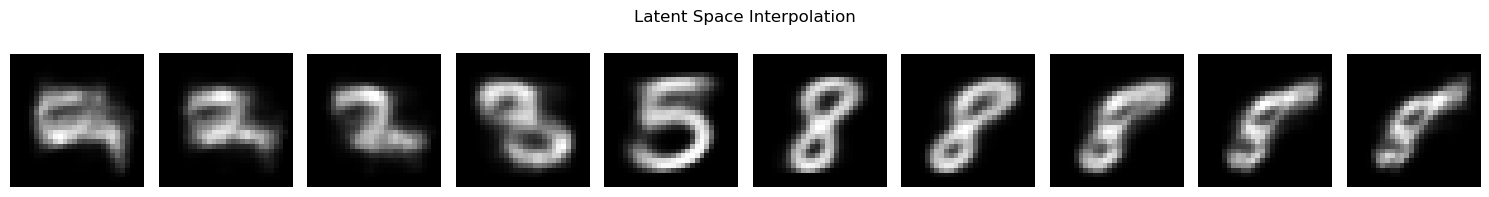

In [39]:
import torch
import torchvision
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor

# Function to convert class labels to one-hot encoding
def one_hot_encoded(x):
    y = torch.zeros(10)
    y[x] = 1
    return y

# Load and prepare MNIST dataset
mnist_train = MNIST(root='./', train=True, download=True, transform=ToTensor(), target_transform=one_hot_encoded)
mnist_test = MNIST(root='./', train=False, download=True, transform=ToTensor(), target_transform=one_hot_encoded)

train_loader = DataLoader(mnist_train, batch_size=32, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size=64, shuffle=True)

# Improved VAE model implementation
class VAE(nn.Module):
    def __init__(self, input_shape, latent_shape):
        self.input_shape = input_shape
        self.latent_shape = latent_shape
        super(VAE, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(in_features=input_shape, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=32),
            nn.ReLU(),
        )
        
        self.mu = nn.Linear(in_features=32, out_features=latent_shape)
        self.log_var = nn.Linear(in_features=32, out_features=latent_shape)
        
        self.decoder = nn.Sequential(
            nn.Linear(in_features=latent_shape, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=input_shape),
            nn.Sigmoid()
        )

    def encode(self, x):
        encoded = self.encoder(x)
        mu = self.mu(encoded)
        log_var = self.log_var(encoded)
        return mu, log_var
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)  # Get standard deviation
        eps = torch.randn_like(std)      # Sample from standard normal
        z = mu + eps * std               # Reparameterization trick
        return z
    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        reconstructed = self.decode(z)
        
        # KL divergence: -0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
        kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp(), dim=1)
        
        return reconstructed, mu, log_var, kl_div

# Initialize model and optimizer
model = VAE(28*28, 2).cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Use Binary Cross Entropy loss for binary images
bce_loss = nn.BCELoss(reduction='sum')

num_epochs = 10
kl_losses = []
recon_losses = []
total_losses = []

# Beta coefficient for KL divergence weighting (beta-VAE technique)
beta = 1.0

# Training loop
with tqdm(total=num_epochs * len(train_loader)) as pbar:
    for epoch in range(num_epochs):
        epoch_kl_loss = 0
        epoch_recon_loss = 0
        epoch_total_loss = 0
        
        for batch_idx, (images, _) in enumerate(train_loader):
            # Flatten and move to device
            images = images.view(-1, 28*28).cuda()
            
            # Reset gradients
            optimizer.zero_grad()
            
            # Forward pass
            reconstructed, mu, log_var, kl = model(images)
            
            # Reconstruction loss
            recon_loss = bce_loss(reconstructed, images)
            
            # Total KL divergence
            kl_loss = kl.mean()
            
            # Total loss
            loss = recon_loss + beta * kl_loss
            
            # Backward pass
            loss.backward()
            
            # Optimize
            optimizer.step()
            
            # Track losses
            epoch_kl_loss += kl_loss.item()
            epoch_recon_loss += recon_loss.item()
            epoch_total_loss += loss.item()
            
            # Update progress bar
            pbar.update(1)
            pbar.set_description(f"Epoch {epoch+1} | Loss: {loss.item():.4f} | Recon: {recon_loss.item():.4f} | KL: {kl_loss.item():.4f}")
        
        # Average epoch losses
        avg_kl = epoch_kl_loss / len(train_loader)
        avg_recon = epoch_recon_loss / len(train_loader)
        avg_total = epoch_total_loss / len(train_loader)
        
        # Save for plotting
        kl_losses.append(avg_kl)
        recon_losses.append(avg_recon)
        total_losses.append(avg_total)
        
        print(f"Epoch {epoch+1}/{num_epochs} | Total Loss: {avg_total:.4f} | Recon: {avg_recon:.4f} | KL: {avg_kl:.4f}")

# Plot losses
plt.figure(figsize=(10, 6))
plt.plot(kl_losses, label="KL Loss")
plt.plot(recon_losses, label="Reconstruction Loss")
plt.plot(total_losses, label="Total Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("VAE Training Losses")
plt.legend()
plt.show()

# Visualize the latent space
def visualize_latent_space(model, device='cuda'):
    # Create a grid of latent space coordinates
    grid_x, grid_y = torch.meshgrid(torch.linspace(-3, 3, 10), torch.linspace(-3, 3, 10))
    grid_z = torch.stack([grid_x.flatten(), grid_y.flatten()], dim=1).to(device)
    
    # Generate images from the latent vectors
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # No need to track gradients
        decoded = model.decode(grid_z)  # Use decode method directly
    
    # Create figure
    fig, axes = plt.subplots(10, 10, figsize=(15, 15))
    
    # Plot each image
    for i in range(10):
        for j in range(10):
            idx = i * 10 + j
            img = decoded[idx].view(28, 28).detach().cpu().numpy()
            axes[i, j].imshow(img, cmap='gray')
            axes[i, j].axis('off')
    
    plt.subplots_adjust(wspace=0.05, hspace=0.05)
    plt.tight_layout()
    plt.show()

# Plot encoded digits in latent space
def plot_latent_space_with_labels(model, test_loader, num_samples=2000):
    model.eval()
    samples = []
    labels = []
    
    with torch.no_grad():
        for i, (x, y) in enumerate(test_loader):
            x = x.view(-1, 28*28).cuda()
            mu, _ = model.encode(x)
            samples.append(mu.cpu())
            labels.append(y.cpu())
            
            if len(samples) * len(x) >= num_samples:
                break
                
    samples = torch.cat(samples, dim=0)[:num_samples]
    labels = torch.cat(labels, dim=0)[:num_samples]
    
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(samples[:, 0], samples[:, 1], c=labels.argmax(dim=1), 
                          cmap='tab10', alpha=0.8, s=10)
    plt.colorbar(scatter, ticks=range(10))
    plt.title('Latent Space Visualization with Digit Labels')
    plt.xlabel('z[0]')
    plt.ylabel('z[1]')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# Run the visualizations
visualize_latent_space(model)
plot_latent_space_with_labels(model, test_loader)

# Generate images by interpolating in latent space
def interpolate_latent_space(model, num_steps=10):
    # Choose 2 different points in latent space
    z1 = torch.tensor([-2.0, -2.0]).cuda()
    z2 = torch.tensor([2.0, 2.0]).cuda()
    
    # Create interpolated points
    steps = torch.linspace(0, 1, num_steps)
    z_interp = torch.stack([(1-t) * z1 + t * z2 for t in steps])
    
    # Generate images
    model.eval()
    with torch.no_grad():
        decoded = model.decode(z_interp)
    
    # Plot interpolation
    fig, axes = plt.subplots(1, num_steps, figsize=(15, 2))
    for i in range(num_steps):
        img = decoded[i].view(28, 28).detach().cpu().numpy()
        axes[i].imshow(img, cmap='gray')
        axes[i].axis('off')
    
    plt.suptitle("Latent Space Interpolation")
    plt.tight_layout()
    plt.show()

# Visualize interpolation
interpolate_latent_space(model)